In [1]:
import os
import glob
import wandb
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict

import tensorflow as tf
import tensorflow.keras as keras
from alibi.models.tensorflow.autoencoder import AE
from alibi.models.tensorflow.actor_critic import Actor, Critic
from alibi.models.tensorflow.cfrl_models import MNISTEncoder, MNISTDecoder, MNISTClassifier
from alibi.explainers.cfrl_base import CounterfactualRLBase, ExperienceCallback, TrainingCallback

%load_ext autoreload
%autoreload 2

/home/robert/anaconda3/envs/dl/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


## Load MNIST dataset

In [2]:
# load mnist dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
BATCH_SIZE = 64

# define trainset
trainset_classifier = tf.data.Dataset.from_tensor_slices((
    np.expand_dims(X_train, axis=-1).astype(np.float) / 255., Y_train))
trainset_classifier = trainset_classifier.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# define testset
testset_classifier = tf.data.Dataset.from_tensor_slices(
    (np.expand_dims(X_test, axis=-1).astype(np.float) / 255., Y_test))
testset_classifier = testset_classifier.shuffle(buffer_size=1024).batch(BATCH_SIZE)

### Define and train classifier

In [3]:
# number of classes
num_classes = 10

# define classifier path
classifier_path = "tensorflow/classifier/"
if not os.path.exists(classifier_path):
    os.makedirs(classifier_path)


# define classifier
classifier = MNISTClassifier(output_dim=num_classes)

# define optimizer and loss
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# fit and compile
classifier.compile(optimizer=optimizer, 
                   loss=loss,
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


if len(os.listdir(classifier_path)) == 0:
    # fit and save the classifier
    classifier.fit(trainset_classifier, epochs=5)
    classifier.save(classifier_path)
else:
    # load the classifier
    classifier = keras.models.load_model(classifier_path)

In [4]:
# evaluate the classifier
classifier.evaluate(testset_classifier)

157/157 [==============================] - 3s 7ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9878


[0.03089391440153122, 0.9901999831199646]

### Define and train AE

In [5]:
# define trainset
trainset_ae = tf.data.Dataset.from_tensor_slices(
    np.expand_dims(X_train, axis=-1).astype(np.float) / 255.
)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# define testset
testset_ae = tf.data.Dataset.from_tensor_slices(
    np.expand_dims(X_test, axis=-1).astype(np.float) / 255.
)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [6]:
# define autoencoder path
ae_path = "tensorflow/autoencoder"
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

# define autoencoder
latent_dim = 64
ae = AE(encoder=MNISTEncoder(latent_dim=latent_dim),
        decoder=MNISTDecoder())

# define optimizer and loss
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)

# compile autoencoder
ae.compile(optimizer=optimizer, loss=loss)

if len(os.listdir(ae_path)) == 0:
    # fit and save autoencoder
    ae.fit(trainset_ae, epochs=50)
    ae.save(ae_path)
else:
    # load the model
    ae = keras.models.load_model(ae_path)

### Test the autoencoder

In [7]:
# get some random samples from test
num_samples = 5
np.random.seed(0)
indices = np.random.choice(X_test.shape[0], num_samples)
inputs = [X_test[i].reshape(1, 28, 28, 1) for i in indices]
inputs = np.concatenate(inputs, axis=0) / 255.

# pass samples through the autoencoder
inputs_hat = ae(inputs).numpy()

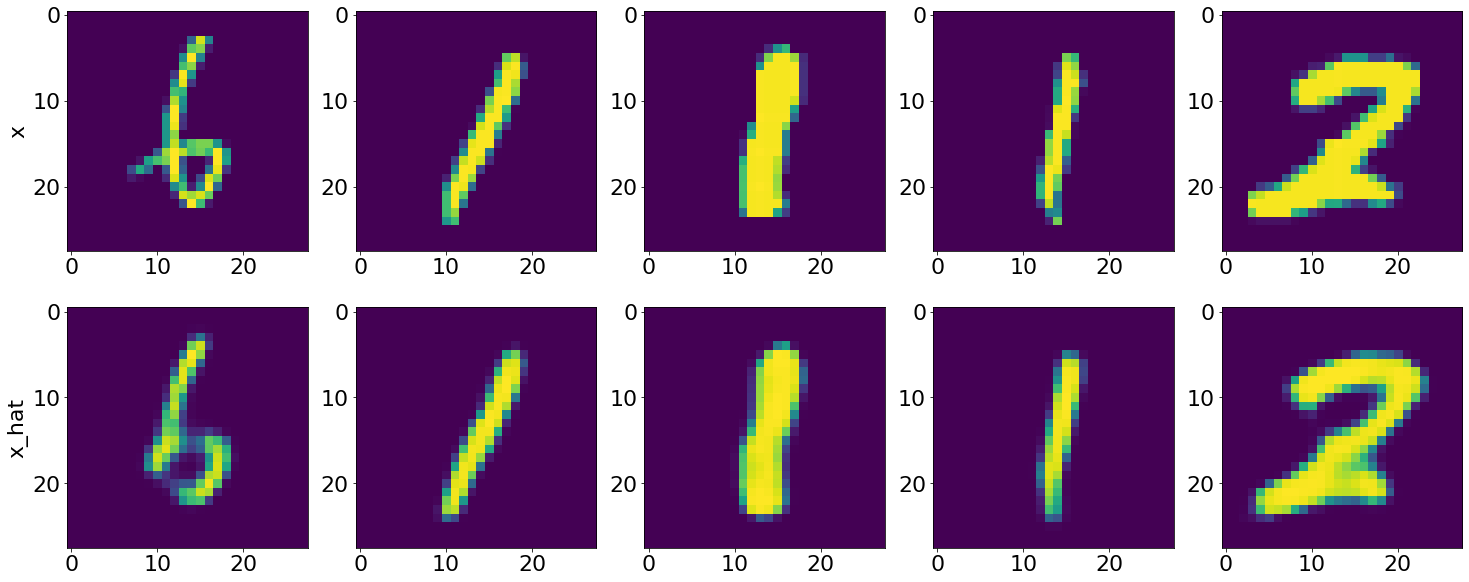

In [8]:
# plot inputs and reconstructions
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2, num_samples, figsize=(25, 10))

for i in range(num_samples):
    ax[0][i].imshow(inputs[i])
    ax[1][i].imshow(inputs_hat[i])
    

text1 = ax[0][0].set_ylabel("x")
text2 = ax[1][0].set_ylabel("x_hat")        

### Counterfactual RL

In [9]:
# define prediction function
def predictor(X: np.ndarray):
    Y = classifier(X).numpy()
    return Y

In [10]:
class RewardCallback(ExperienceCallback):
    def __call__(self,
                 step: int, 
                 model: CounterfactualRLBase, 
                 sample: Dict[str, np.ndarray]):
        if step % 100 != 0:
            return
        
        # get the counterfactual and target
        X_cf = sample["X_cf"]
        Y_t = sample["Y_t"]
        
        # get prediction label
        Y_m_cf = predictor(X_cf)
        
        # compute reward
        reward = np.mean(model.params["reward_func"](Y_m_cf, Y_t))
        wandb.log({"reward": reward})
        
class DisplayImgsCallback(ExperienceCallback):
    def __call__(self,
                 step:int,
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray]):
        if step % 100 != 0:
            return
        
        # defie number of samples to be displayed
        num_sample = 5
        
        X = sample["X"][:num_samples]        # input instance
        X_cf = sample["X_cf"][:num_samples]  # counterfactual
        diff = np.abs(X - X_cf)              # differences
        
        Y_m = sample["Y_m"][:num_samples].astype(int)   # input labels
        Y_t = sample["Y_t"][:num_samples].astype(int)   # target labels
        Y_m_cf = predictor(X_cf).astype(int)         # counterfactual labels
        
        # concatentate images
        X = np.concatenate(X, axis=1)
        X_cf = np.concatenate(X_cf, axis=1)
        diff = np.concatenate(diff, axis=1)
        
        # construct image
        img = np.concatenate([X, X_cf, diff], axis=0)
            
        # construct caption
        caption = ""
        caption += "Input:\t%s\n" % str(list(np.argmax(Y_m, axis=1)))
        caption += "Target:\t%s\n" % str(list(np.argmax(Y_t, axis=1)))
        caption += "Predicted:\t%s\n" % str(list(np.argmax(Y_m_cf, axis=1)))
        
        # log image
        wandb.log({"samples": wandb.Image(img, caption=caption)})


class DisplayLossCallback(TrainingCallback):
    def __call__(self,
                 step: int, 
                 update: int, 
                 model: CounterfactualRLBase,
                 sample: Dict[str, np.ndarray],
                 losses: Dict[str, float]):
        # log training losses
        if (step + update) % 100 == 0:
            wandb.log(losses)

In [11]:
# define ddpg
explainer = CounterfactualRLBase(predictor=predictor,
                                 encoder=ae.encoder,
                                 decoder=ae.decoder,
                                 latent_dim=latent_dim,
                                 coeff_sparsity=7.5,
                                 coeff_consistency=0,
                                 backend="tensorflow",
                                 experience_callbacks=[RewardCallback(), DisplayImgsCallback()],
                                 train_callbacks=[DisplayLossCallback()],
                                 train_steps=1000,
                                 batch_size=100)

In [12]:
# perpare data: add channel and normalize
X = np.expand_dims(X_train, axis=-1) / 255.

In [13]:
# initialize wandb
wandb_project = "MNIST CounterfactualRL"
wandb.init(project=wandb_project)

# fit the explainer
explainer.fit(X=X)

# close wandb
wandb.finish()

wandb: Currently logged in as: rfs (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


100%|██████████| 1000/1000 [00:26<00:00, 37.28it/s]


reward,0.07
_runtime,30
_timestamp,1627921873
_step,28
loss_critic,0.07399
loss_actor,-0.31328
sparsity_loss,0.0619
consistency_loss,0


reward,▁▄▆▄▄▂█▄▄▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss_critic,▅▂██▃▆▁▅▄
loss_actor,▁█▆▇█▇█▇▇
sparsity_loss,█▆▆▆▆▅▃▁▁
consistency_loss,▁▁▁▁▁▁▁▁▁


### Save explainer

In [14]:
explainer.save("cfrl_base")

INFO:tensorflow:Assets written to: cfrl_base/encoder.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/encoder.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/decoder.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/decoder.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/actor.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/actor.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/critic.tf/assets


INFO:tensorflow:Assets written to: cfrl_base/critic.tf/assets


### Load explainer

In [15]:
explainer = CounterfactualRLBase.load("cfrl_base", predictor=predictor)

### Test loaded explainer

In [16]:
# explain instances
explanation = explainer.explain(X[0:200], Y_t=np.array([1]), batch_size=100)

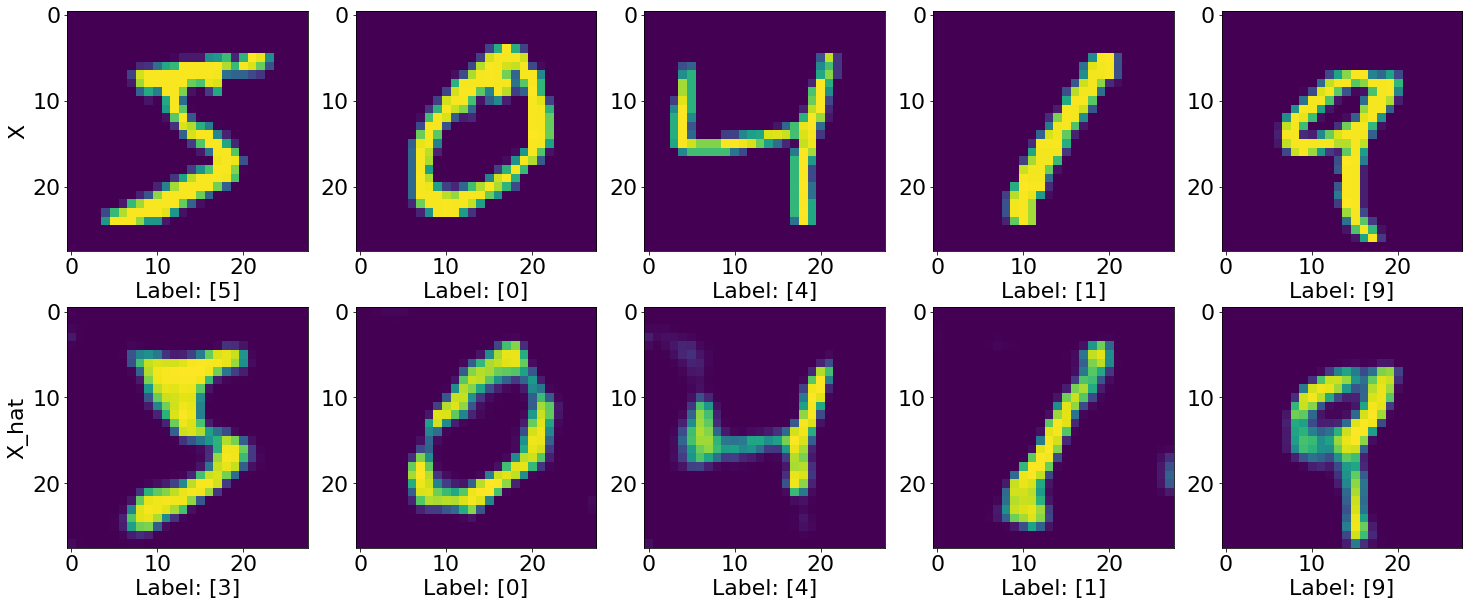

In [17]:
fig, ax = plt.subplots(2, num_samples, figsize=(25, 10))

for i in range(num_samples):
    ax[0][i].imshow(explanation.data['orig']['X'][i])
    ax[1][i].imshow(explanation.data['cf']['X'][i])
    
    ax[0][i].set_xlabel("Label: " + str(explanation.data['orig']['class'][i]))
    ax[1][i].set_xlabel("Label: " + str(explanation.data['cf']['class'][i]))
    

text1 = ax[0][0].set_ylabel("X")
text2 = ax[1][0].set_ylabel("X_hat")    